In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

## Importing & exploring the dataset

In [10]:
train = pd.read_csv('data/train.csv')

In [11]:
# Checking data type for each columns

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
UniqueID                               233154 non-null int64
disbursed_amount                       233154 non-null int64
asset_cost                             233154 non-null int64
ltv                                    233154 non-null float64
branch_id                              233154 non-null int64
supplier_id                            233154 non-null int64
manufacturer_id                        233154 non-null int64
Current_pincode_ID                     233154 non-null int64
Date.of.Birth                          233154 non-null object
Employment.Type                        225493 non-null object
DisbursalDate                          233154 non-null object
State_ID                               233154 non-null int64
Employee_code_ID                       233154 non-null int64
MobileNo_Avl_Flag                      233154 non-null int64
Aadhar_flag                   

In [12]:
# Checking for null values

train.isnull().sum()

UniqueID                                  0
disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                

In [14]:
# Check unique values for each column

train.nunique()

UniqueID                               233154
disbursed_amount                        24565
asset_cost                              46252
ltv                                      6579
branch_id                                  82
supplier_id                              2953
manufacturer_id                            11
Current_pincode_ID                       6698
Date.of.Birth                           15433
Employment.Type                             2
DisbursalDate                              84
State_ID                                   22
Employee_code_ID                         3270
MobileNo_Avl_Flag                           1
Aadhar_flag                                 2
PAN_flag                                    2
VoterID_flag                                2
Driving_flag                                2
Passport_flag                               2
PERFORM_CNS.SCORE                         573
PERFORM_CNS.SCORE.DESCRIPTION              20
PRI.NO.OF.ACCTS                   

In [19]:
# Getting unique values as %

col_uniq_pct = pd.DataFrame(train.nunique()/len(train)).reset_index()
col_uniq_pct.columns = ['column', 'unique_pct']

In [20]:
col_uniq_pct

,column,unique_pct
0,UniqueID,1.000000
1,disbursed_amount,0.105360
2,asset_cost,0.198375
3,ltv,0.028217
4,branch_id,0.000352
5,supplier_id,0.012665
6,manufacturer_id,0.000047
7,Current_pincode_ID,0.028728
8,Date.of.Birth,0.066192
9,Employment.Type,0.000009


In [16]:
# Exploring credit history length column to identify the reason for getting dtype 'object'

train['CREDIT.HISTORY.LENGTH'].head()

0     0yrs 0mon
1    1yrs 11mon
2     0yrs 0mon
3     1yrs 3mon
4     0yrs 0mon
Name: CREDIT.HISTORY.LENGTH, dtype: object

In [21]:
# Checking for data imbalance

train['loan_default'].value_counts()

0    182543
1     50611
Name: loan_default, dtype: int64

In [22]:
# Checking imbalance in %

train['loan_default'].value_counts()/train['loan_default'].value_counts().sum()

0    0.782929
1    0.217071
Name: loan_default, dtype: float64

## Data pre-processing

1. FIll the null values in employment type with 'Unspecified'
2. Identify columns that are categorical in nature but numeric by dtype & convert them to 'object'
3. Identify columns that are numeric in nature but categorical by dtype & convert them to 'int' / 'float'
4. Remove columns that has only 1 unique value or all values are unique
5. Calculate age using disbursal date and DOB and delete disbursal date and DOB columns
6. Remove redundant columns

In [23]:
# 1. FIll the null values in employment type with 'Unspecified'

train['Employment.Type'].fillna('Unspecified', inplace=True)

In [26]:
# Verify the null imputation

print(train['Employment.Type'].isnull().sum())
print('-' * 30)
print(train['Employment.Type'].value_counts())

0
------------------------------
Self employed    127635
Salaried          97858
Unspecified        7661
Name: Employment.Type, dtype: int64


In [27]:
# 2. Identify columns that are categorical in nature but numeric by dtype & convert them to 'object'

col_uniq_pct[col_uniq_pct['unique_pct'] < 0.1]

,column,unique_pct
3,ltv,0.028217
4,branch_id,0.000352
5,supplier_id,0.012665
6,manufacturer_id,0.000047
7,Current_pincode_ID,0.028728
8,Date.of.Birth,0.066192
9,Employment.Type,0.000009
10,DisbursalDate,0.000360
11,State_ID,0.000094
12,Employee_code_ID,0.014025


Shortlisted = branch_id, supplier_id, manufacturer_id, Current_pincode_ID, State_ID, Employee_code_ID, MobileNo_Avl_Flag, Aadhar_flag, PAN_flag, Driving_flag, Passport_flag

In [28]:
# 3. Identify columns that are numeric in nature but categorical by dtype & convert them to 'int' / 'float'

# Create a function for conversion

def cred_hist_asint(length):
    """
    Converts X yrs Y mnths to int (months) 
    """
    return (int(length.split(' ')[0].replace('yrs', ''))*12) + int(length.split(' ')[1].replace('mon', ''))

In [29]:
# Test the function

cred_hist_asint('1yrs 11mon')

23

In [31]:
# Convert the column to int

train['CREDIT.HISTORY.LENGTH'] = train['CREDIT.HISTORY.LENGTH'].map(lambda x: cred_hist_asint(x))

In [34]:
# Verify the conversion

train['CREDIT.HISTORY.LENGTH'].head()

0     0
1    23
2     0
3    15
4     0
Name: CREDIT.HISTORY.LENGTH, dtype: int64

In [167]:
# Apply same treatment for average account age

train['AVERAGE.ACCT.AGE'] = train['AVERAGE.ACCT.AGE'].map(lambda x: cred_hist_asint(x))

In [35]:
# 4. Remove columns that has only 1 unique value or all values are unique

#Retainng the UniqueID for now. Will drop it during Analysis

train.drop('MobileNo_Avl_Flag', axis=1, inplace=True)

In [37]:
# 5. Calculate age using disbursal date and DOB and delete disbursal date and DOB columns

train[['Date.of.Birth', 'DisbursalDate']].head()

,Date.of.Birth,DisbursalDate
0,01-01-84,03-08-18
1,31-07-85,26-09-18
2,24-08-85,01-08-18
3,30-12-93,26-10-18
4,09-12-77,26-09-18


In [39]:
# Check unique year of disbursal

set([i.split('-')[-1] for i in train['DisbursalDate'].values])

{'18'}

In [40]:
set([i.split('-')[-1] for i in train['Date.of.Birth'].values])

{'00',
 '49',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99'}

In [43]:
# Create a function for age calculation

def disb_age(dob):
    """
    Calculates Age in years from DOB and Disbursal Date
    """
    yob = dob.strip().split('-')[-1]
    if yob != '00':
        yob = int('19' + yob)
    else:
        yob = 2000
        
    return 2018 - yob

In [44]:
# Test the function

disb_age(dob='01-01-84')

34

In [46]:
# Crete an age column and detele DOB and Disbursal date

train['disb_age'] = train['Date.of.Birth'].map(lambda x: disb_age(x))

In [47]:
train.drop(['Date.of.Birth', 'DisbursalDate'], axis=1, inplace=True)

In [49]:
# 6. Remove redundant columns

# As PERFORM_CNS.SCORE.DESCRIPTION and PERFORM_CNS.SCORE provide the same info will reatin the score column as it is 
# numeric and ML algorithms generally perform well on numeric data

train.drop('PERFORM_CNS.SCORE.DESCRIPTION', axis=1, inplace=True)

In [50]:
# Verify the revised columns

train.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID',
       'Employment.Type', 'State_ID', 'Employee_code_ID', 'Aadhar_flag',
       'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag',
       'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'disb_age'],
      dtype='object')

## EDA

1. Are there any high risk states / branches / suppliers / manufacturers / employees?
2. Does having more accounts impact risk of defaulting?
3. Does recent delinquency have any impact on risk of defaulting?
4. Does credit score / credit history length hold any importance for identifying potential defaulters?
5. Does employment type have an effect on chance of defaulting?
6. Check the age distribution

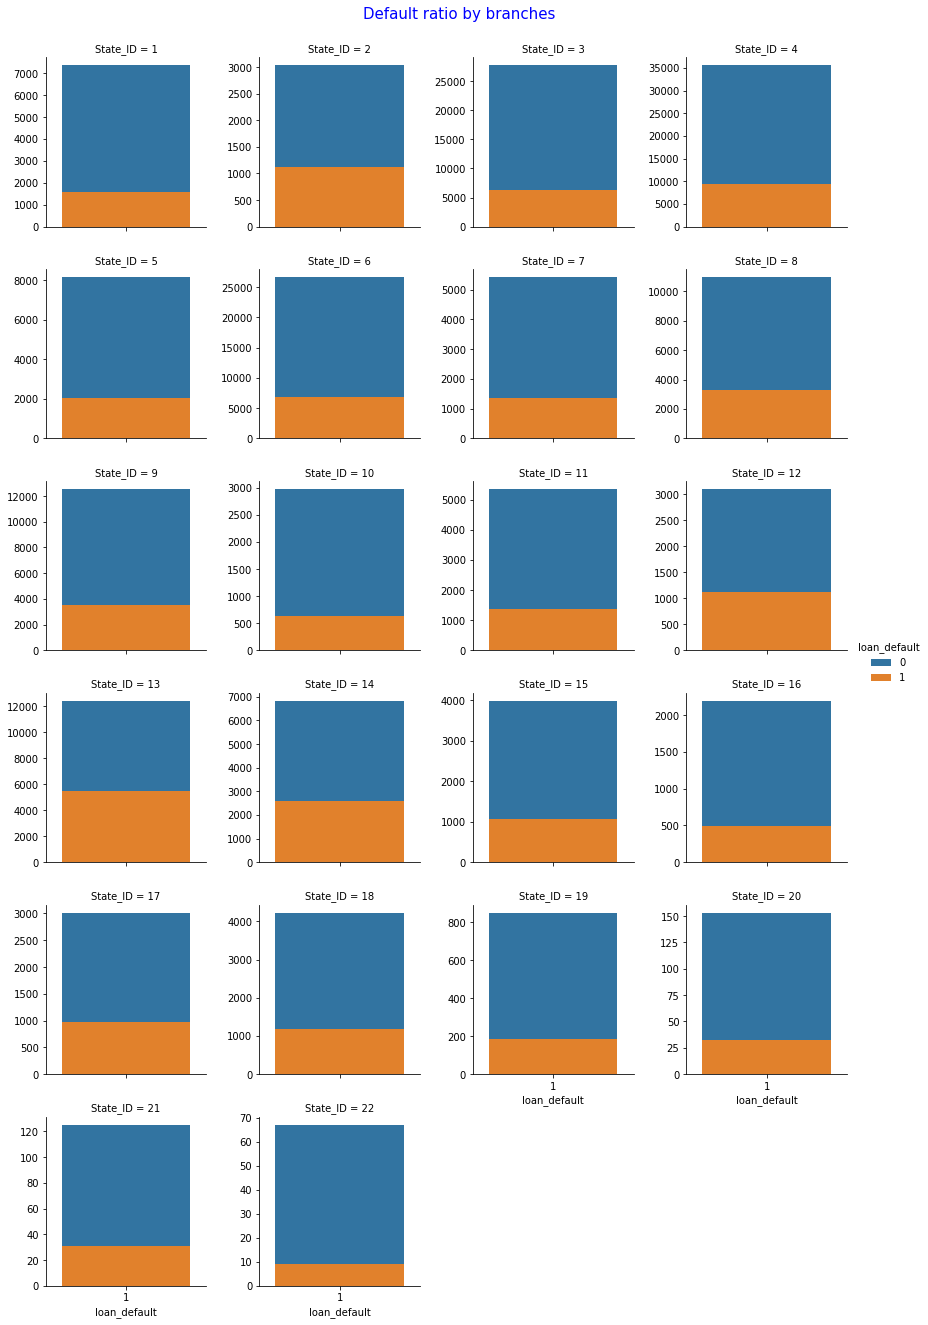

In [113]:
# High risk branches

g = sns.FacetGrid(train, col='State_ID', col_wrap=4, hue='loan_default', sharey=False)
g.map(sns.countplot, 'loan_default').add_legend()
plt.suptitle('Defaulter ratio by branches', y=1.02, fontsize=15, color='blue')
plt.show()

In [73]:
# Top 10 branches based on risk

top10_branch = train.pivot_table(index='branch_id', values='loan_default', aggfunc='mean').sort_values('loan_default', ascending=False)[:10]

In [74]:
top10_branch

,loan_default
branch_id,
251,0.343913
254,0.324308
97,0.313625
36,0.296762
78,0.291476
153,0.286127
117,0.283154
146,0.282552
105,0.282468


In [84]:
# Top 10 suppliers based on risk

top10_suppliers = train.pivot_table(index='supplier_id', values='loan_default', aggfunc=['mean', 'count'])

In [89]:
top10_suppliers.columns = ['loan_default', 'volume']

In [94]:
top10_suppliers[top10_suppliers['volume'] > 20].sort_values(['loan_default', 'volume'], ascending=[False, False])

,loan_default,volume
supplier_id,,
23356,0.761905,21
24200,0.727273,33
22880,0.652174,23
20972,0.645161,31
22994,0.559016,610
23150,0.542857,105
23518,0.538462,26
24250,0.529412,85
24006,0.529412,34


In [95]:
# Top 10 maufacturers based on risk

top10_manufacturers = train.pivot_table(index='manufacturer_id', values='loan_default', aggfunc=['mean', 'count'])

In [96]:
top10_manufacturers

,mean,count
,loan_default,loan_default
manufacturer_id,,
45,0.228499,56626
48,0.272531,16710
49,0.218787,10220
51,0.207947,27204
67,0.217464,2405
86,0.204594,109534
120,0.220750,9658
145,0.200514,778


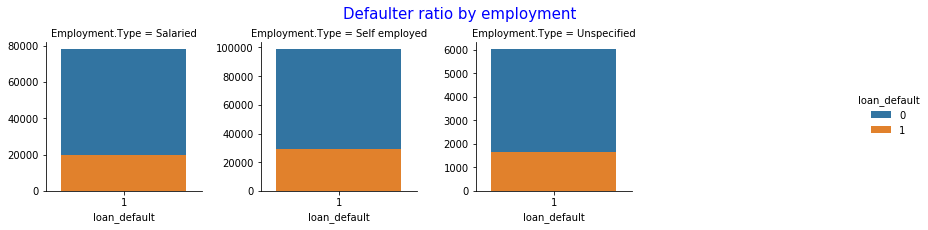

In [115]:
# Does employment type have an effect on chance of defaulting? 

g = sns.FacetGrid(train, col='Employment.Type', col_wrap=4, hue='loan_default', sharey=False)
g.map(sns.countplot, 'loan_default').add_legend()
plt.suptitle('Defaulter ratio by employment', y=1.05, fontsize=15, color='blue')
plt.show()

In [98]:
train.pivot_table(index='Employment.Type', values='loan_default', aggfunc='mean')

,loan_default
Employment.Type,
Salaried,0.203458
Self employed,0.227657
Unspecified,0.214593


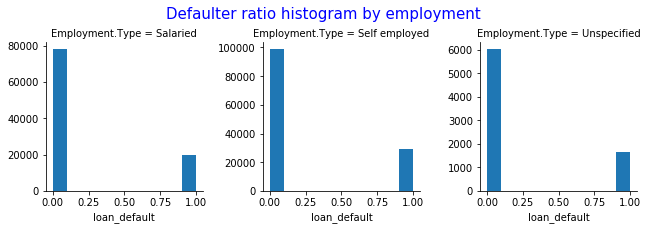

In [119]:
g = sns.FacetGrid(train, col='Employment.Type', sharey=False, col_wrap=3)
g.map(plt.hist, 'loan_default')
plt.suptitle('Defaulter ratio histogram by employment', y=1.05, fontsize=15, color='blue')
plt.show()

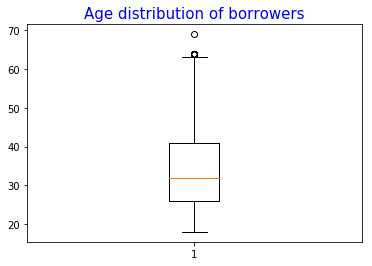

In [118]:
# Checking age distribution

plt.boxplot(train['disb_age'])
plt.title('Age distribution of borrowers', fontsize=15, color='blue')
plt.show()

In [107]:
# Other EDA questions to be practised

## Feature Engineering

1. Convert categorical to int
2. Combinig all the flag columns as a single column for total documents

In [125]:
# Converting all IDs to sensible numbers (Risk of default - inspired by WOE)

id_ls = ['branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'State_ID', 'Employee_code_ID', ]

for col in id_ls:
    newcol = col + '_risk'
    train[newcol] = train.groupby(col)['loan_default'].transform('mean')

In [126]:
# Understand the output

train[['branch_id', 'branch_id_risk']]

,branch_id,branch_id_risk
0,67,0.194032
1,67,0.194032
2,67,0.194032
3,67,0.194032
4,67,0.194032
5,67,0.194032
6,67,0.194032
7,67,0.194032
8,67,0.194032
9,67,0.194032


In [128]:
# Drop all the IDs columns

train.drop(id_ls, axis=1, inplace=True)

In [129]:
# Verify columns

train.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'Employment.Type',
       'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag',
       'Passport_flag', 'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS',
       'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
       'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
       'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE',
       'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT',
       'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE',
       'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'loan_default', 'disb_age',
       'branch_id_risk', 'supplier_id_risk', 'manufacturer_id_risk',
       'Current_pincode_ID_risk', 'State_ID_risk', 'Employee_code_ID_risk'],
      dtype='object')

In [133]:
# Convert employment type to int using OHE

train = pd.get_dummies(train, columns=['Employment.Type'], drop_first=True)

In [134]:
# Verify columns

train.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'Aadhar_flag',
       'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag',
       'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'disb_age', 'branch_id_risk', 'supplier_id_risk',
       'manufacturer_id_risk', 'Current_pincode_ID_risk', 'State_ID_risk',
       'Employee_code_ID_risk', 'Employment.Type_Self employed',
       'Employment.Type_Unspecified'],
      dtype='object')

In [135]:
# Print head

train.head()

,UniqueID,disbursed_amount,asset_cost,ltv,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,...,loan_default,disb_age,branch_id_risk,supplier_id_risk,manufacturer_id_risk,Current_pincode_ID_risk,State_ID_risk,Employee_code_ID_risk,Employment.Type_Self employed,Employment.Type_Unspecified
0,420825,50578,58400,89.55,1,0,0,0,0,0,...,0,34,0.194032,0.363636,0.228499,0.055556,0.205641,0.37037,0,0
1,537409,47145,65550,73.23,1,0,0,0,0,598,...,1,33,0.194032,0.363636,0.228499,0.285714,0.205641,0.37037,1,0
2,417566,53278,61360,89.63,1,0,0,0,0,0,...,0,33,0.194032,0.363636,0.228499,0.234043,0.205641,0.37037,1,0
3,624493,57513,66113,88.48,1,0,0,0,0,305,...,1,25,0.194032,0.363636,0.228499,0.133333,0.205641,0.37037,1,0
4,539055,52378,60300,88.39,1,0,0,0,0,0,...,1,41,0.194032,0.363636,0.228499,0.642857,0.205641,0.37037,1,0


In [138]:
# Creating a column for total document counts

train['total_docs'] = train.apply(lambda x: x['Aadhar_flag'] + x['PAN_flag'] + x['VoterID_flag'] + x['Driving_flag'] + x['Passport_flag'], axis=1)

In [140]:
# Drop individual flag columns

flagls = [i for i in train.columns if 'flag' in i.lower()]
train.drop(flagls, axis=1, inplace=True)

In [141]:
# Verify columns

train.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv',
       'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'disb_age', 'branch_id_risk', 'supplier_id_risk',
       'manufacturer_id_risk', 'Current_pincode_ID_risk', 'State_ID_risk',
       'Employee_code_ID_risk', 'Employment.Type_Self employed',
       'Employment.Type_Unspecified', 'total_docs'],
      dtype='object')

## Feature Selection

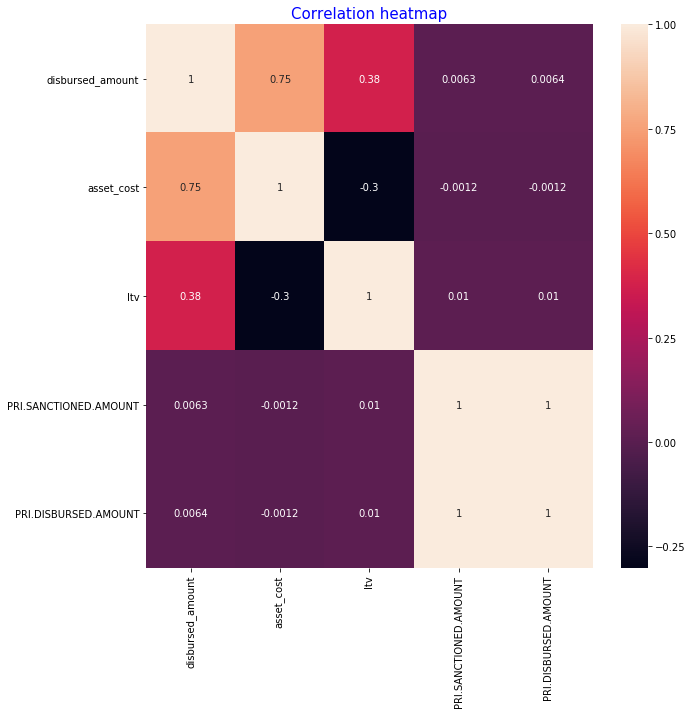

In [149]:
# Drop features with multicolinearity

fig = plt.figure(figsize=(10, 10))
sns.heatmap(train[['disbursed_amount', 'asset_cost', 'ltv', 'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT']].corr(), annot=True)
plt.title('Correlation heatmap', fontsize=15, color='blue')
plt.show()

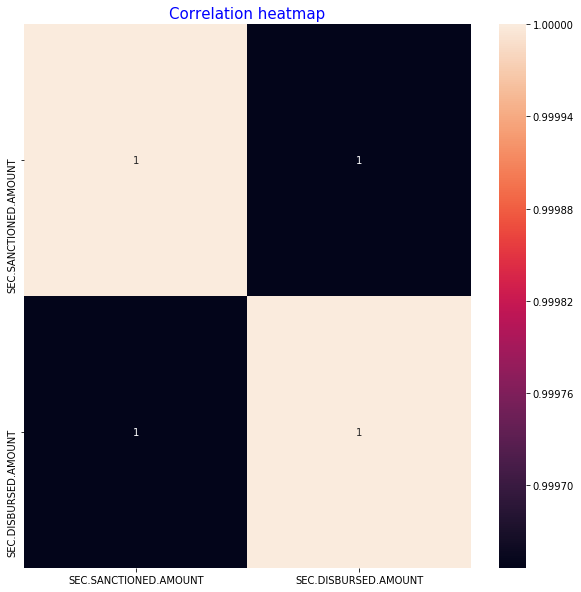

In [151]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(train[['SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT']].corr(), annot=True)
plt.title('Correlation heatmap', fontsize=15, color='blue')
plt.show()

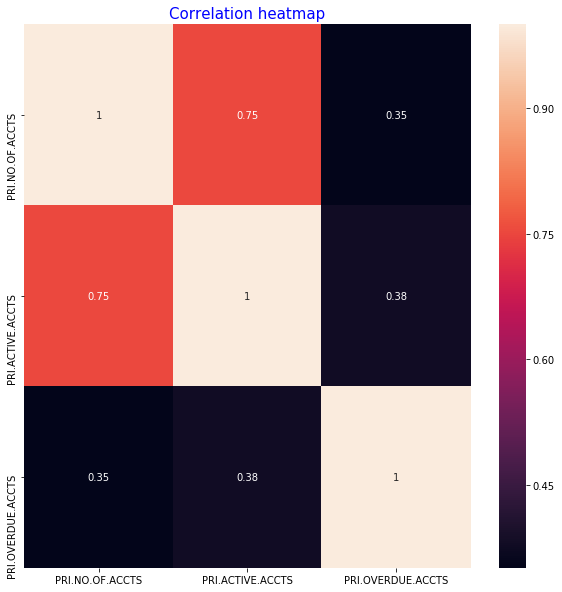

In [155]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(train[['PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS']].corr(), annot=True)
plt.title('Correlation heatmap', fontsize=15, color='blue')
plt.show()

* Will drop Asset cost as disbursed amount has more impact on defaulting. More the disbursed amount, more the risk
* WIll drop Sanctioned amount
* Will drop primary account and focus on active accounts (Same trend for secondary)

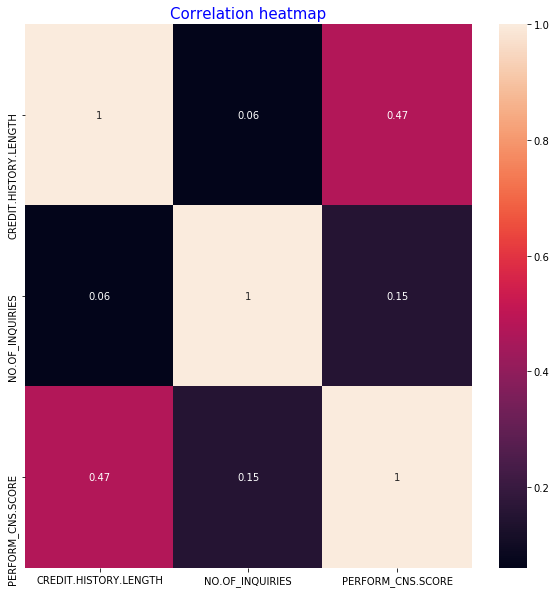

In [152]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(train[['CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'PERFORM_CNS.SCORE']].corr(), annot=True)
plt.title('Correlation heatmap', fontsize=15, color='blue')
plt.show()

In [156]:
# Dropping columns

train.drop(['asset_cost', 'PRI.NO.OF.ACCTS', 'SEC.NO.OF.ACCTS', 
            'PRI.SANCTIONED.AMOUNT', 'SEC.SANCTIONED.AMOUNT'], axis=1, inplace=True)

In [159]:
# Verify columns

train.columns

Index(['UniqueID', 'disbursed_amount', 'ltv', 'PERFORM_CNS.SCORE',
       'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
       'PRI.DISBURSED.AMOUNT', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS',
       'SEC.CURRENT.BALANCE', 'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT',
       'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE',
       'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'loan_default', 'disb_age',
       'branch_id_risk', 'supplier_id_risk', 'manufacturer_id_risk',
       'Current_pincode_ID_risk', 'State_ID_risk', 'Employee_code_ID_risk',
       'Employment.Type_Self employed', 'Employment.Type_Unspecified',
       'total_docs'],
      dtype='object')

In [168]:
# Create X and y

X = train.drop(['UniqueID', 'loan_default'], axis=1)
y = train['loan_default']

In [187]:
# Use RFE for feature selection

logr = LogisticRegression()
rfe = RFE(logr, 15)

In [188]:
rfe.fit(X, y)

/home/sagar/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sagar/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sagar/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sagar/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sagar/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='warn', n_jobs=None, penalty='l2',
                                 random_state=None, solver='warn', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=15, step=1, verbose=0)

In [189]:
sel_cols = []
for a, b, c in zip(rfe.support_, rfe.ranking_, X.columns):
    print(a, b, c)
    if b == 1:
        sel_cols.append(c)

False 8 disbursed_amount
False 3 ltv
False 7 PERFORM_CNS.SCORE
True 1 PRI.ACTIVE.ACCTS
True 1 PRI.OVERDUE.ACCTS
False 10 PRI.CURRENT.BALANCE
False 13 PRI.DISBURSED.AMOUNT
True 1 SEC.ACTIVE.ACCTS
False 2 SEC.OVERDUE.ACCTS
False 14 SEC.CURRENT.BALANCE
False 9 SEC.DISBURSED.AMOUNT
False 11 PRIMARY.INSTAL.AMT
False 12 SEC.INSTAL.AMT
True 1 NEW.ACCTS.IN.LAST.SIX.MONTHS
True 1 DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS
False 6 AVERAGE.ACCT.AGE
False 5 CREDIT.HISTORY.LENGTH
True 1 NO.OF_INQUIRIES
False 4 disb_age
True 1 branch_id_risk
True 1 supplier_id_risk
True 1 manufacturer_id_risk
True 1 Current_pincode_ID_risk
True 1 State_ID_risk
True 1 Employee_code_ID_risk
True 1 Employment.Type_Self employed
True 1 Employment.Type_Unspecified
True 1 total_docs


In [190]:
print(sel_cols)

['PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'SEC.ACTIVE.ACCTS', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES', 'branch_id_risk', 'supplier_id_risk', 'manufacturer_id_risk', 'Current_pincode_ID_risk', 'State_ID_risk', 'Employee_code_ID_risk', 'Employment.Type_Self employed', 'Employment.Type_Unspecified', 'total_docs']


In [191]:
# Creating new DF of X

X_sel = X[sel_cols]

## Preparing baseline model

In [192]:
# Split data in to train and test

X_train, X_test, y_train, y_test = train_test_split(X_sel, y, train_size=0.7, random_state=7)

In [193]:
logr.fit(X_train, y_train)

/home/sagar/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [194]:
y_pred = logr.predict(X_test)

In [196]:
print(accuracy_score(y_test, y_pred))

0.7862381517434629


In [197]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.98      0.88     54695
           1       0.56      0.09      0.15     15252

    accuracy                           0.79     69947
   macro avg       0.68      0.53      0.51     69947
weighted avg       0.74      0.79      0.72     69947



In [199]:
# Attempt using RF

rf = RandomForestClassifier()

In [200]:
rf.fit(X_train, y_train)

/home/sagar/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [201]:
y_pred_rf = rf.predict(X_test)

In [202]:
print(accuracy_score(y_test, y_pred_rf))

0.7500965016369537


In [203]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85     54695
           1       0.34      0.16      0.22     15252

    accuracy                           0.75     69947
   macro avg       0.57      0.54      0.54     69947
weighted avg       0.70      0.75      0.71     69947

